In [ ]:
!pip install rapidfuzz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 19.0 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/ZhaoyueSun/PHEE.git

Cloning into 'PHEE'...
remote: Enumerating objects: 9984, done.
remote: Counting objects: 100% (9984/9984), done.
remote: Compressing objects: 100% (9736/9736), done.
remote: Total 9984 (delta 69), reused 9968 (delta 59), pack-reused 0 (from 0)
Receiving objects: 100% (9984/9984), 11.31 MiB | 10.53 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Updating files: 100% (9962/9962), done.


In [ ]:
import pandas as pd
import json
file_path = "PHEE/data/json/train.json"

records = []

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        record = json.loads(line.strip())
        sentence = record["context"]
        for annotation in record.get("annotations", []):
            for event in annotation.get("events", []):
                trigger = " ".join(event.get("Trigger", {}).get("text", [[""]])[0])
                drug = " ".join(event.get("Treatment", {}).get("Drug", {}).get("text", [[""]])[0])
                effect = " ".join(event.get("Effect", {}).get("text", [[""]])[0])

                records.append({
                    "sentence": sentence,
                    "trigger": trigger,
                    "drug": drug,
                    "effect": effect
                })

df = pd.DataFrame(records)
df.head(100)

,sentence,trigger,drug,effect
0,OBJECTIVE: To test the hypothesis that tumor n...,induced,insulin,lipoatrophies
1,An evaluation of ovarian structure and functio...,develop,valproate,menstrual cycle disturbances
2,Phenobarbital hepatotoxicity in an 8-month-old...,in,Phenobarbital,hepatotoxicity
3,The authors report a case of Balint syndrome w...,following,methotrexate,Balint syndrome with irreversible posterior le...
4,"According to the Naranjo probability scale, fl...",cause,flecainide,delirium
...,...,...,...,...
95,The development of cutaneous ecchymosis associ...,development,alteplase,cutaneous ecchymosis a sudden fall in hemoglob...
96,We report a case of papillary necrosis in a pa...,treated,indinavir,papillary necrosis
97,Generalized maculopapular and papular purpuric...,induced,thionamide,Generalized maculopapular and papular purpuric...
98,Imidazoline intoxication due to overdose or ac...,due,,intoxication


In [ ]:
unique_drugs = df["drug"].str.lower().dropna().unique().tolist()
unique_effects = df["effect"].str.lower().dropna().unique().tolist()

print(f"Total unique drugs: {len(unique_drugs)}")
print(f"Total unique effects: {len(unique_effects)}")

Total unique drugs: 894
Total unique effects: 2016


In [ ]:
# Create temporary IDs
drug_mapping = {drug: f"DRUG_{i+1}" for i, drug in enumerate(unique_drugs)}
effect_mapping = {effect: f"EFFECT_{i+1}" for i, effect in enumerate(unique_effects)}

# Apply to DataFrame
df["drug_id"] = df["drug"].str.lower().map(drug_mapping)
df["effect_id"] = df["effect"].str.lower().map(effect_mapping)

df.head(100)

,sentence,trigger,drug,effect,drug_id,effect_id
0,OBJECTIVE: To test the hypothesis that tumor n...,induced,insulin,lipoatrophies,DRUG_1,EFFECT_1
1,An evaluation of ovarian structure and functio...,develop,valproate,menstrual cycle disturbances,DRUG_2,EFFECT_2
2,Phenobarbital hepatotoxicity in an 8-month-old...,in,Phenobarbital,hepatotoxicity,DRUG_3,EFFECT_3
3,The authors report a case of Balint syndrome w...,following,methotrexate,Balint syndrome with irreversible posterior le...,DRUG_4,EFFECT_4
4,"According to the Naranjo probability scale, fl...",cause,flecainide,delirium,DRUG_5,EFFECT_5
...,...,...,...,...,...,...
95,The development of cutaneous ecchymosis associ...,development,alteplase,cutaneous ecchymosis a sudden fall in hemoglob...,DRUG_87,EFFECT_89
96,We report a case of papillary necrosis in a pa...,treated,indinavir,papillary necrosis,DRUG_88,EFFECT_90
97,Generalized maculopapular and papular purpuric...,induced,thionamide,Generalized maculopapular and papular purpuric...,DRUG_89,EFFECT_91
98,Imidazoline intoxication due to overdose or ac...,due,,intoxication,DRUG_90,EFFECT_92


In [ ]:
!pip install spacy --quiet
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 106.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess_spacy(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    tokens_no_stop = [token.text for token in doc if not token.is_stop]
    tokens_lemma = [token.lemma_ for token in doc if not token.is_stop]
    sentences = [sent.text for sent in doc.sents]
    return tokens, tokens_no_stop, tokens_lemma, sentences

df[["tokens", "tokens_no_stop", "tokens_lemma", "sentences_split"]] = df["sentence"].apply(lambda x: pd.Series(preprocess_spacy(x)))

In [ ]:
df["sentence_lower"] = df["sentence"].str.lower()
import string
df["tokens_no_punct"] = df["tokens_lemma"].apply(lambda tokens: [t for t in tokens if t not in string.punctuation])
df["tokens_no_numbers"] = df["tokens_no_punct"].apply(lambda tokens: [t if not t.isdigit() else "<NUM>" for t in tokens])
from nltk import ngrams
df["bigrams"] = df["tokens_no_numbers"].apply(lambda tokens: list(ngrams(tokens, 2)))
df.head(20)

,sentence,trigger,drug,effect,drug_id,effect_id,tokens,tokens_no_stop,tokens_lemma,sentences_split,sentence_lower,tokens_no_punct,tokens_no_numbers,bigrams
0,OBJECTIVE: To test the hypothesis that tumor n...,induced,insulin,lipoatrophies,DRUG_1,EFFECT_1,"[OBJECTIVE, :, To, test, the, hypothesis, that...","[OBJECTIVE, :, test, hypothesis, tumor, necros...","[objective, :, test, hypothesis, tumor, necros...",[OBJECTIVE: To test the hypothesis that tumor ...,objective: to test the hypothesis that tumor n...,"[objective, test, hypothesis, tumor, necrosis,...","[objective, test, hypothesis, tumor, necrosis,...","[(objective, test), (test, hypothesis), (hypot..."
1,An evaluation of ovarian structure and functio...,develop,valproate,menstrual cycle disturbances,DRUG_2,EFFECT_2,"[An, evaluation, of, ovarian, structure, and, ...","[evaluation, ovarian, structure, function, con...","[evaluation, ovarian, structure, function, con...",[An evaluation of ovarian structure and functi...,an evaluation of ovarian structure and functio...,"[evaluation, ovarian, structure, function, con...","[evaluation, ovarian, structure, function, con...","[(evaluation, ovarian), (ovarian, structure), ..."
2,Phenobarbital hepatotoxicity in an 8-month-old...,in,Phenobarbital,hepatotoxicity,DRUG_3,EFFECT_3,"[Phenobarbital, hepatotoxicity, in, an, 8, -, ...","[Phenobarbital, hepatotoxicity, 8, -, month, -...","[phenobarbital, hepatotoxicity, 8, -, month, -...",[Phenobarbital hepatotoxicity in an 8-month-ol...,phenobarbital hepatotoxicity in an 8-month-old...,"[phenobarbital, hepatotoxicity, 8, month, old,...","[phenobarbital, hepatotoxicity, <NUM>, month, ...","[(phenobarbital, hepatotoxicity), (hepatotoxic..."
3,The authors report a case of Balint syndrome w...,following,methotrexate,Balint syndrome with irreversible posterior le...,DRUG_4,EFFECT_4,"[The, authors, report, a, case, of, Balint, sy...","[authors, report, case, Balint, syndrome, irre...","[author, report, case, Balint, syndrome, irrev...",[The authors report a case of Balint syndrome ...,the authors report a case of balint syndrome w...,"[author, report, case, Balint, syndrome, irrev...","[author, report, case, Balint, syndrome, irrev...","[(author, report), (report, case), (case, Bali..."
4,"According to the Naranjo probability scale, fl...",cause,flecainide,delirium,DRUG_5,EFFECT_5,"[According, to, the, Naranjo, probability, sca...","[According, Naranjo, probability, scale, ,, fl...","[accord, Naranjo, probability, scale, ,, fleca...","[According to the Naranjo probability scale, f...","according to the naranjo probability scale, fl...","[accord, Naranjo, probability, scale, flecaini...","[accord, Naranjo, probability, scale, flecaini...","[(accord, Naranjo), (Naranjo, probability), (p..."
5,Contact dermatitis due to budesonide: report o...,due,budesonide,Contact dermatitis,DRUG_6,EFFECT_6,"[Contact, dermatitis, due, to, budesonide, :, ...","[Contact, dermatitis, budesonide, :, report, c...","[contact, dermatitis, budesonide, :, report, c...",[Contact dermatitis due to budesonide: report ...,contact dermatitis due to budesonide: report o...,"[contact, dermatitis, budesonide, report, case...","[contact, dermatitis, budesonide, report, case...","[(contact, dermatitis), (dermatitis, budesonid..."
6,Prolongation of the QT interval observed in a ...,following,halofantrine,Prolongation of the QT interval,DRUG_7,EFFECT_7,"[Prolongation, of, the, QT, interval, observed...","[Prolongation, QT, interval, observed, Japanes...","[prolongation, QT, interval, observe, japanese...",[Prolongation of the QT interval observed in a...,prolongation of the qt interval observed in a ...,"[prolongation, QT, interval, observe, japanese...","[prolongation, QT, interval, observe, japanese...","[(prolongation, QT), (QT, interval), (interval..."
7,We report three cases of severe hepatotoxicity...,related,benzarone,severe hepatotoxicity,DRUG_8,EFFECT_8,"[We, report, three, cases, of, severe, hepatot...","[report, cases, seve

In [ ]:
import json

# Build dictionary: drug -> list of effects
drug_to_effects = df.groupby("drug")["effect"].apply(lambda x: list(set(x.dropna()))).to_dict()

# Save as JSON
with open("drug_to_effects.json", "w", encoding="utf-8") as f:
    json.dump(drug_to_effects, f, indent=4, ensure_ascii=False)

print("Saved drug-to-effects dictionary as drug_to_effects.json")

Saved drug-to-effects dictionary as drug_to_effects.json


In [ ]:
from google.colab import files
files.download("drug_to_effects.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

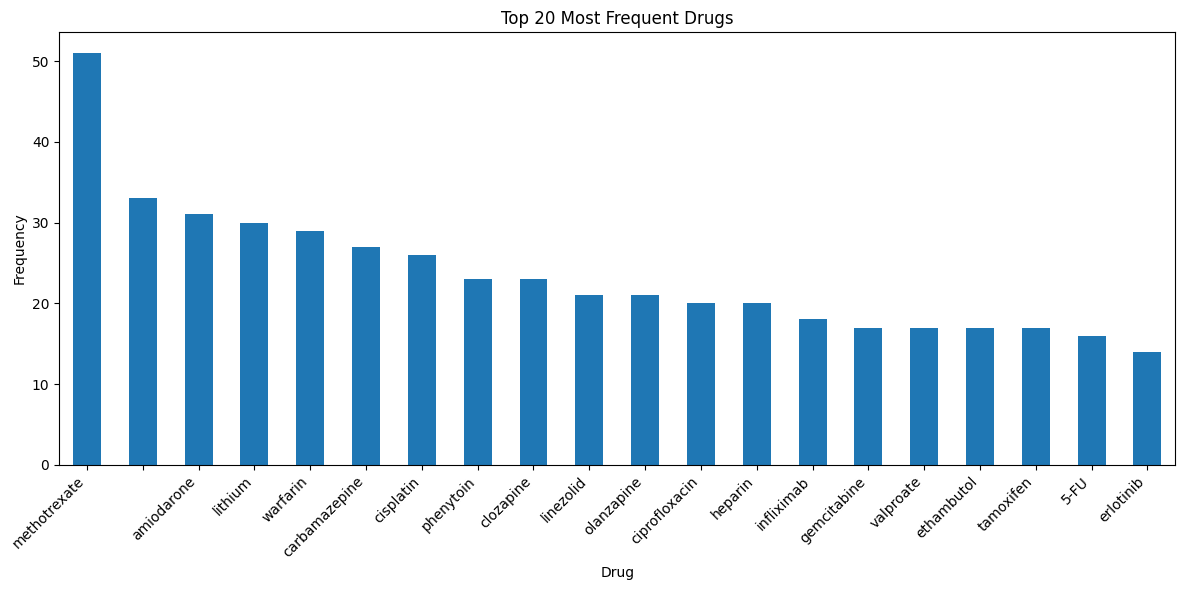

In [ ]:
import matplotlib.pyplot as plt

# Get the top 20 most frequent drugs
top_drugs = df["drug"].value_counts().nlargest(20)

# Create a bar plot (histogram)
plt.figure(figsize=(12, 6))
top_drugs.plot(kind='bar')
plt.title("Top 20 Most Frequent Drugs")
plt.xlabel("Drug")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

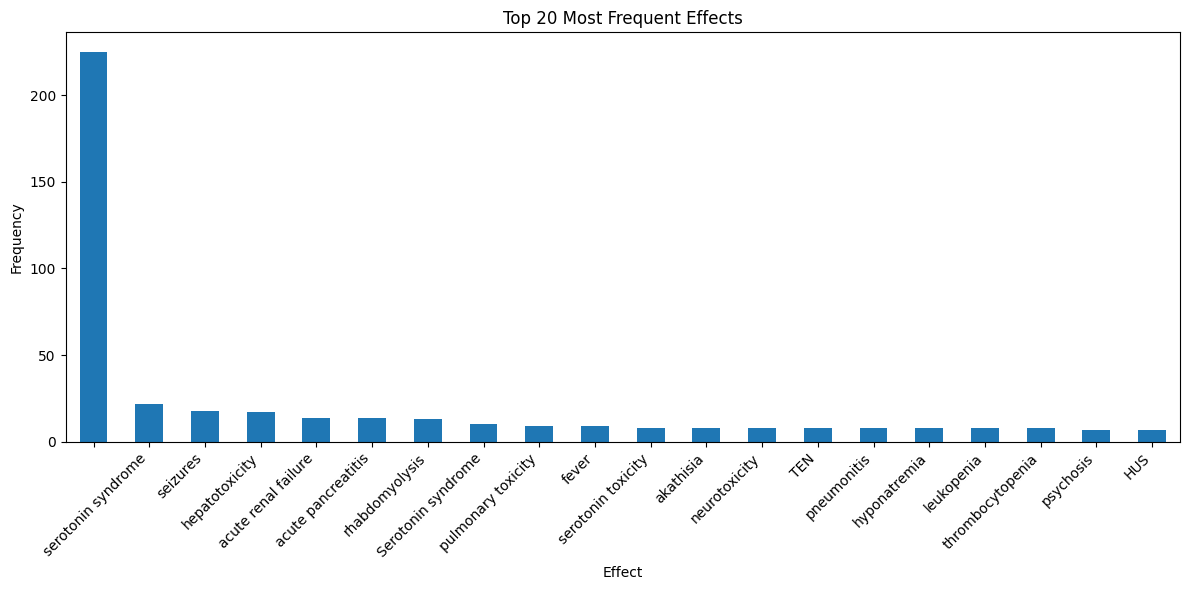

In [ ]:
import matplotlib.pyplot as plt

# Get the top 20 most frequent effects
top_effects = df["effect"].value_counts().nlargest(20)

# Create a bar plot (histogram)
plt.figure(figsize=(12, 6))
top_effects.plot(kind='bar')
plt.title("Top 20 Most Frequent Effects")
plt.xlabel("Effect")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

**Classifier (ADE vs Non-ADE)**

In [ ]:
import json
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Note: The original EXTRACT_FILE path has been changed to use the uploaded JSON file.
# Since the original file 'extractions.json' was not provided, we will use 'drug_to_effects.json'.
EXTRACT_FILE = Path("drug_to_effects.json")


# ---- STEP 1: Load sentences from the JSON file ----
def load_sentences_from_person2():
    sentences = []
    # The uploaded file has a dictionary structure, not a list of dictionaries.
    # We will extract all the effects listed in the values.
    with open(EXTRACT_FILE, "r", encoding="utf8") as f:
        data = json.load(f)
    for effects_list in data.values():
        for sentence in effects_list:
            # Filter out any empty strings that may be present in the lists.
            if sentence.strip():
                sentences.append(sentence.strip())
    return sentences


# ---- STEP 2: Demo training data ----
train_sentences = [
    "patient developed rash after aspirin",
    "subject took vitamin C",
    "he experienced nausea due to ibuprofen",
    "she is healthy and took paracetamol"
]
train_labels = [1, 0, 1, 0]   # 1 = ADE, 0 = Non-ADE


# ---- STEP 3: Train classifier ----
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentences)

clf = LogisticRegression()
clf.fit(X_train, train_labels)


def classify_sentence(text: str):
    """Classify a sentence as ADE or Non-ADE"""
    X = vectorizer.transform([text])
    label = clf.predict(X)[0]
    confidence = clf.predict_proba(X).max()
    return "ADE" if label == 1 else "Non-ADE", round(confidence, 3)


# ---- STEP 4: Example usage ----
if __name__ == "__main__":
    sentences = load_sentences_from_person2()
    # For demonstration, we'll only classify the first 10 sentences
    # to provide a concise output.
    for s in sentences[:50]:
        label, conf = classify_sentence(s)
        print(f"{s}  --> {label} (conf={conf})")

persisting cystoid macular edema  --> ADE (conf=0.508)
anemia  --> ADE (conf=0.508)
the likelihood of further episodes of seizures improve the outcome of treatment-resistant schizophrenia  --> ADE (conf=0.508)
isolated serum CK elevation  --> ADE (conf=0.508)
intoxication  --> ADE (conf=0.508)
CNS lymphoma  --> ADE (conf=0.508)
incapacitating myalgias in neck, thighs and arms  --> Non-ADE (conf=0.534)
presenting with right-sided paralysis and aphasia  --> Non-ADE (conf=0.534)
akathisia  --> ADE (conf=0.508)
severe dysphagia and bleeding  --> Non-ADE (conf=0.534)
multiform ventricular tachycardia  --> ADE (conf=0.508)
Methotrexate pneumonitis  --> ADE (conf=0.508)
polyuria  --> ADE (conf=0.508)
neuromyeloencephalopathy  --> ADE (conf=0.508)
Serotonin syndrome,  --> ADE (conf=0.508)
mucositis  --> ADE (conf=0.508)
Oral mucositis  --> ADE (conf=0.508)
peripheral neuropathy  --> ADE (conf=0.508)
delayed encephalopathy  --> ADE (conf=0.508)
lung disorder  --> ADE (conf=0.508)
Upper gastroin